# TrES-3b transmission spectroscopy: contamination

*<a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a>, University of Oxford*

***The aperture used to calculate the TrES-3 spectra contains a faint background star, here we calculate how much it contributes to the total flux.***

This notebook is a part in a series of notebooks working as an appendix to Parviainen et al. (2015, submitted), aiming to make the analysis presented in the paper easily reproductable. The results and the figures presented in the paper can be reproduced by following these notebooks in the numbered order.

*Dependencies:* See `000_README.ipynb` for the list of required Python packages, and how to install them.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from glob import glob
from scipy.ndimage import median_filter as mf
from scipy.optimize import fmin

from pyfc import psf_g1d
from core import *

In [3]:
def multig_model(pv, size, ncomp=3, return_comps=False):
    m = zeros([ncomp, size])
    for i in range(ncomp):
        m[i,:] = psf_g1d(pv[0], pv[1+i*2], pv[2+i*2], size)
    
    if return_comps:
        return m
    else:
        return m.sum(0)
        
def model(pv, size, nct=3, ncc=2, return_comps=False):
    m_target = multig_model(pv[:1+2*nct], size, nct)
    m_contam = multig_model(pv[1+2*nct:], size, ncc)
    
    if return_comps:
        return m_target, m_contam
    else:
        return m_target+m_contam 
    
def integrate_mg(pv):
    """Returns the integral of n Gaussians with an amplitude A and fwhm F."""
    return sum(pv[0::2]*pv[1::2]/2.355*sqrt(2*pi))

In [4]:
ffile = join(dir_data,'example_gtc_object_frame.fits')
gain  = pf.getval(ffile, 'gain', ext=0)
frame = pf.getdata(ffile,2) * gain
flux  = frame[500:700:,400:450].mean(0)
sky   = frame[500:700:,445:475].mean()
logflux = log10(flux-sky)

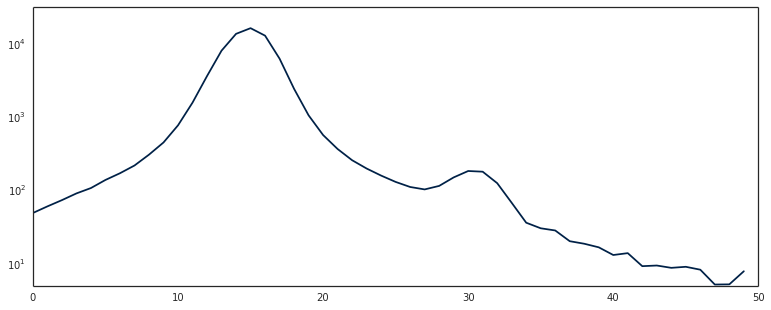

In [5]:
semilogy(flux-sky)
ylim(5,3.2e4);

In [6]:
res = fmin(lambda pv: ((logflux-log10(model(pv, flux.size, 4, 3, False)))**2).sum(), 
           [15.5, 2e4, 4.2,  5e3, 7,  1e3, 15,  1e2, 40,   
            31, 2e2,5, 5e1, 10, 5, 15], maxfun=40000, maxiter=40000)

Optimization terminated successfully.
         Current function value: 0.060060
         Iterations: 16884
         Function evaluations: 21923


In [7]:
mt, mc = model(res, flux.size, 4, 3, True)

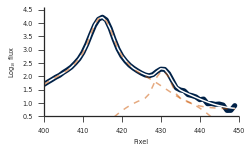

In [8]:
x = arange(400,400+flux.size)
with sb.plotting_context('paper', rc=rc_paper):
    with sb.axes_style('ticks'):
        fig,ax = subplots(1,1,figsize=(AAOCW,0.6*AAOCW))
        ax.plot(x,logflux, '-', lw=5, c=c_ob)
        ax.plot(x,log10(mt+mc), 'w-', lw=1.5)
        ax.plot(x,log10(mt), '--', c=c_bo, alpha=0.5, lw=1.5)
        ax.plot(x,log10(mc), '--', c=c_bo, alpha=0.5, lw=1.5)
    setp(ax, ylim=(0.5,4.6), ylabel='Log$_{10}$ flux', xlabel='Pixel')
    sb.despine(fig)
    fig.tight_layout()
    fig.savefig('plots/pub_contamination.pdf')

In [9]:
I1 = integrate_mg(res[1:1+2*4])
I2 = integrate_mg(res[2+2*4:])
print I2/(I1+I2)

0.0107482284745


---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>